In [6]:
import random
import numpy as np
from qiskit import*
from qiskit.circuit.library import UnitaryGate

In [2]:
I2 = np.matrix([[1,0],[0,1]])
H  = np.matrix([[1,1],[1,-1]])* (1/np.sqrt(2))
S  = np.matrix([[1,0],[0,1j]])
X  = np.matrix([[0,1],[1,0]])
Y  = np.matrix([[0,-1j],[1j,0]])
Z  = np.matrix([[1,0],[0,-1]])

r"""

Clifford group is defined as the quotient group C_{n}/U(1) which counts elements in C_{n} that differs
only by an overall global phase factor as the same element. In that case, any element of C_{n}/U(1)
can be written as a product a*b where a \in A and b \in B.

"""
A = [I2,S,H,H@S,S@H,H@S@H]
B = [I2,X,Y,Z]

single_qubit_Clifford_group = []
for a in A:
    for b in B:
        single_qubit_Clifford_group.append(a@b)

In [3]:
# Hamiltonians and Lindbladians
b       = 0.1
gamma_1 = 0.2
gamma_2 = 0.3

Hamiltonian = (-b/2)*X
L_1 = np.sqrt(gamma_1)*np.matrix([[0,1],[1,0]])
L_2 = np.sqrt(gamma_2)*Z

# steady state density matrix parameters
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss   = (2*b*gamma_1)/Delta
zss   = (gamma_1*(gamma_1+4*gamma_2))/Delta

# steady state density matrix
rho_ss = (1/2)*(I2+yss*Y+zss*Z)

# angles for steady state preparation
theta_x = np.arccos(zss)
theta_y = np.arccos(-yss/(4*np.sqrt(1+zss**2)))

In [4]:
# function to be determined
def f(rho,X_p,X_q,X_r):
    return np.tr(X_p@rho@X_q@rho@X_r)

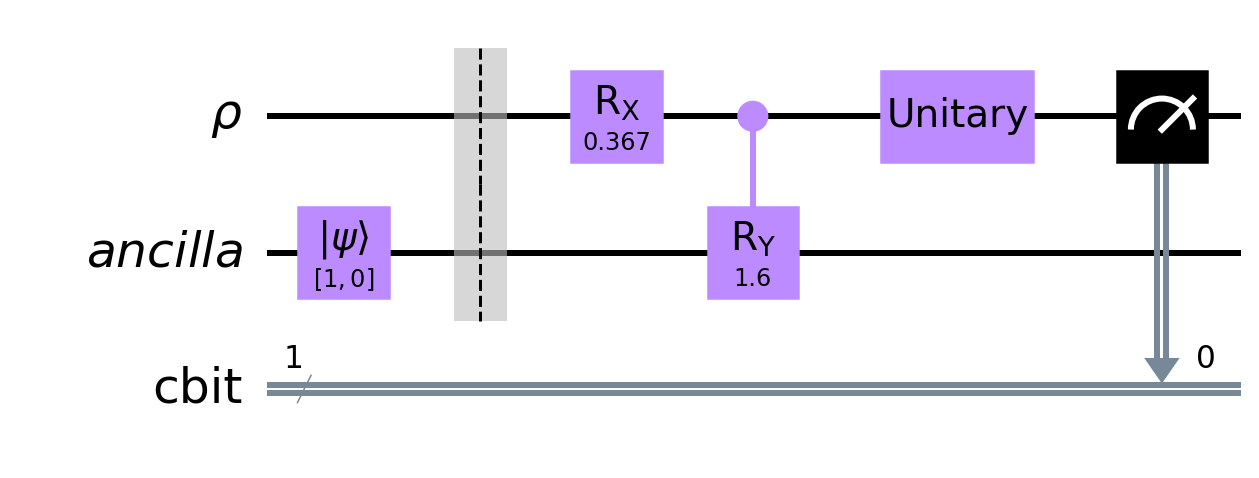

In [30]:
# setting up the quantum circuit
density_matrix_qubit = QuantumRegister(1, r"\rho")
ancilla_qubit = QuantumRegister(1, "ancilla")
cbit = ClassicalRegister(1,"cbit")
qc = QuantumCircuit(density_matrix_qubit,ancilla_qubit,cbit)
# initializing the ancilla qubit at |0>.
qc.initialize([1,0],1)
qc.barrier()
qc.rx(theta_x,0)
qc.cry(theta_y,0,1)

# random Clifford rotation
random_Clifford_gate = UnitaryGate(random.choice(single_qubit_Clifford_group).tolist())
qc.append(random_Clifford_gate,[0])
qc.measure(0,0)
qc.draw("mpl",scale=3)

{'0': 767, '1': 1281}


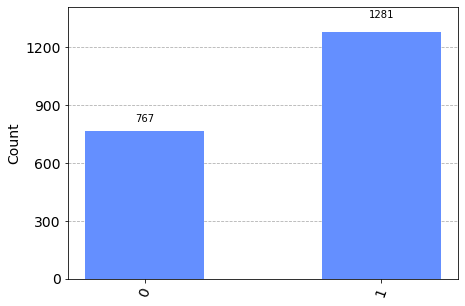

In [42]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=2048)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)